# Libraries

In [13]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re, string, unicodedata
import contractions
import nltk
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [14]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Loading data

In [15]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory)[10000:10100]:
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [16]:
# load stories
directory = r"C:\Users\feder\Desktop\cnn\stories"
data = load_stories(directory)


In [17]:
print('Loaded Stories %d' % len(data))

Loaded Stories 100


# Cleaning and preprocessing


In [18]:
data.head()

,story,highlight
0,"(EW.com) -- After a Friday night showdown that heavily tipped the scales in favor of the survival-horror thriller ""The Purge: Anarchy,"" ""Dawn of the Planet of the Apes"" came back strong this weeke...","[""Dawn of the Planet of the Apes"" was again No. 1 at the box office, It beat new thriller ""The Purge: Anarchy,"" which was No. 2, Cameron Diaz's new comedy ""Sex Tape"" opened in fourth place]"
1,Washington (CNN) -- The Department of Veterans Affairs unveiled new regulations Monday making it easier for men and women who served in the armed forces to receive benefits for post-traumatic stre...,"[New VA rule makes it easier for veterans to get PTSD benefits, Veterans are no longer required to documents specific events causing PTSD, VA acknowledging ""inherently stressful nature ... of mili..."
2,"(CNN) -- A rash of severe weather pummeled several eastern states Tuesday, killing at least five people and leaving about 300,000 people in the dark.\n\nOne boy died and eight other children were ...","[4 people died when buildings collapsed in the Syracuse, New York, area, The storm kills a boy camping with other children in Maryland, 207,000 customers are still without power in Pennsylvania ea..."
3,"(CNN)In addition to Philadelphia, Pope Francis told reporters Monday that he will also visit New York and Washington on his upcoming trip to the United States.\n\nIn September, he is scheduled to ...","[New Yorkers will be ""humbled and honored to hear his message,"" mayor says, Pope Francis tells reporters his U.S. trip will include three cities, In Philadelphia, he'll attend the World Meeting of..."
4,"(CNN) -- The Nevada Supreme Court Friday upheld former football player O.J. Simpson's convictions for kidnapping with a deadly weapon and other charges in his 2008 Las Vegas armed robbery trial, b...","[Nevada Supreme Court finds Simpson's arguments ""without merit"", A codefendant wins a new trial, Simpson will continue a 33-year prison sentence with a chance for parole after nine years, Justices..."


In [19]:
data = data.explode("highlight")

## Normalization

In [20]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [21]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [22]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [23]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [24]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [25]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,friday night showdown heavily tipped scales favor survival horror thriller purge anarchy dawn planet apes came back strong weekend take spot box office apes sequel starring motion capture master a...,starttoken dawn planet apes box office endtoken
0,friday night showdown heavily tipped scales favor survival horror thriller purge anarchy dawn planet apes came back strong weekend take spot box office apes sequel starring motion capture master a...,starttoken beat new thriller purge anarchy endtoken
0,friday night showdown heavily tipped scales favor survival horror thriller purge anarchy dawn planet apes came back strong weekend take spot box office apes sequel starring motion capture master a...,starttoken cameron diaz new comedy sex tape opened fourth place endtoken
1,washington department veterans affairs unveiled new regulations monday making easier men women served armed forces receive benefits post traumatic stress disorder current department rules require ...,starttoken new va rule makes easier veterans get ptsd benefits endtoken
1,washington department veterans affairs unveiled new regulations monday making easier men women served armed forces receive benefits post traumatic stress disorder current department rules require ...,starttoken veterans longer required documents specific events causing ptsd endtoken
...,...,...
98,lest americans forget wellsprings nation france bore torch liberty alongside us old ally launched reminder across atlantic waves l hermione three sail masts bright royal blue gold markings painsta...,starttoken original fought american colonists british revolutionary war endtoken
99,washington united states monday condemned violence libya called halt unacceptable bloodshed response civil unrest secretary state hillary clinton said statement government libya responsibility res...,starttoken new clinton calls bloodshed libya unacceptable endtoken
99,washington united states monday condemned violence libya called halt unacceptable bloodshed response civil unrest secretary state hillary clinton said statement government libya responsibility res...,starttoken state department ordered evacuation non essential personnel endtoken
99,washington united states monday condemned violence libya called halt unacceptable bloodshed response civil unrest secretary state hillary clinton said statement government libya responsibility res...,starttoken obama administration stressing need avoid violence protesters endtoken


In [38]:
x_test = data['cleaned_text']
y_test = data['cleaned_highlight']

## Tokenization

In [29]:
#!pip install pickle5
import  pickle

In [32]:
def open_test_data_y():
    return open('y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [34]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.37335164184758
Total Coverage of rare words: 0.39457576608869416


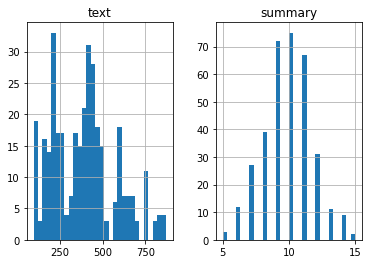

In [35]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [36]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.9942528735632183


In [37]:
max_text_len=300
max_summary_len=12

In [39]:
#convert text sequences into integer sequences
x_test_seq = x_tokenizer.texts_to_sequences(x_test) 



In [40]:
#padding zero upto maximum length
x_test = pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')



In [41]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.13038910359836
Total Coverage of rare words: 12.006825652323979


In [42]:
#convert text sequences into integer sequences
y_test_seq    =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_test    =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')


In [45]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# Saving the data

In [46]:
np.save("../final_data/x_test.npy", x_test)
np.save("../final_data/y_test.npy", y_test)
